In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import os
import numpy as np
import time
import datetime
from matplotlib import pyplot as plt
import csv
import random
from IPython import display
import PIL.Image as Image
import tqdm

In [4]:
train_path = "./train/train_data01/"

train_num = len(os.listdir(train_path))
train_csv_path = "./train/train_data01.csv"

BATCH_SIZE = 100
BUFFER_SIZE = train_num
shape_num = 3
CHANNELS = 3
h = w = 100
epochs = 20
learning_rate = 0.001
beta_1 = 0.9

checkpoint_dir = './training_checkpoints'
log_dir="logs/"

print(f'Total training data = {train_num}')

Total training data = 50000


In [3]:
train_images = []
circle_labels = []
square_labels = []
triangle_labels = []
with open(train_csv_path, newline='') as csvfile:
    rows = csv.reader(csvfile)
    next(rows)
    
    for row in tqdm.tqdm(rows):
        image = np.array(Image.open(train_path+row[0]+'.jpg')).astype(np.float32)/255
        train_images.append(image)
        circle_labels.append((np.array(row[1]).astype(int)-1))
        square_labels.append((np.array(row[2]).astype(int)-1))
        triangle_labels.append((np.array(row[3]).astype(int)-1))
    
    train_images = np.array(train_images)
    circle_labels = np.array(circle_labels)
    square_labels = np.array(square_labels)
    triangle_labels = np.array(triangle_labels)

50000it [00:48, 1041.39it/s]


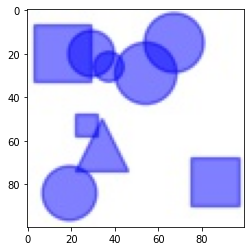

In [4]:
plt.imshow(train_images[0])

In [5]:
circle_labels[0]+1

5

In [2]:
def Model():
    inputs = tf.keras.layers.Input(shape=[h,w,CHANNELS], name='input')
    
    p1 = 64
    p2 = 2 * p1
    
    x = inputs
    x = tf.keras.layers.Conv2D(p1, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(x)
    b1_out = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(b1_out)
    x = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(x)
    b2_out = tf.keras.layers.add([x, b1_out])
    
    x = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(b2_out)
    x = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(x)
    b3_out = tf.keras.layers.add([x, b2_out])
    
    x = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(b3_out)
    
    ci = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(x)
    ci = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(ci)
    ci_out = tf.keras.layers.add([ci, x])
    
    sq = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(x)
    sq = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(sq)
    sq_out = tf.keras.layers.add([sq, x])
    
    tr = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(x)
    tr = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(tr)
    tr_out = tf.keras.layers.add([tr, x])
    
    
    ci = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(ci_out)
    ci = tf.keras.layers.GlobalAveragePooling2D()(ci)
    ci = tf.keras.layers.Dense(512, activation="relu")(ci)
    ci = tf.keras.layers.Dense(128, activation="relu")(ci)
    ci = tf.keras.layers.Dense(5, name="circle")(ci)
    
    sq = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(sq_out)
    sq = tf.keras.layers.GlobalAveragePooling2D()(sq)
    sq = tf.keras.layers.Dense(512, activation="relu")(sq)
    sq = tf.keras.layers.Dense(128, activation="relu")(sq)
    sq = tf.keras.layers.Dense(5, name="square")(sq)
    
    tr = tf.keras.layers.Conv2D(p2, 3, padding='same', activation='relu')(tr_out)
    tr = tf.keras.layers.GlobalAveragePooling2D()(tr)
    tr = tf.keras.layers.Dense(512, activation="relu")(tr)
    tr = tf.keras.layers.Dense(128, activation="relu")(tr)
    tr = tf.keras.layers.Dense(5, name="triangle")(tr)
    
    return tf.keras.Model(inputs=inputs, outputs=[ci, sq, tr])

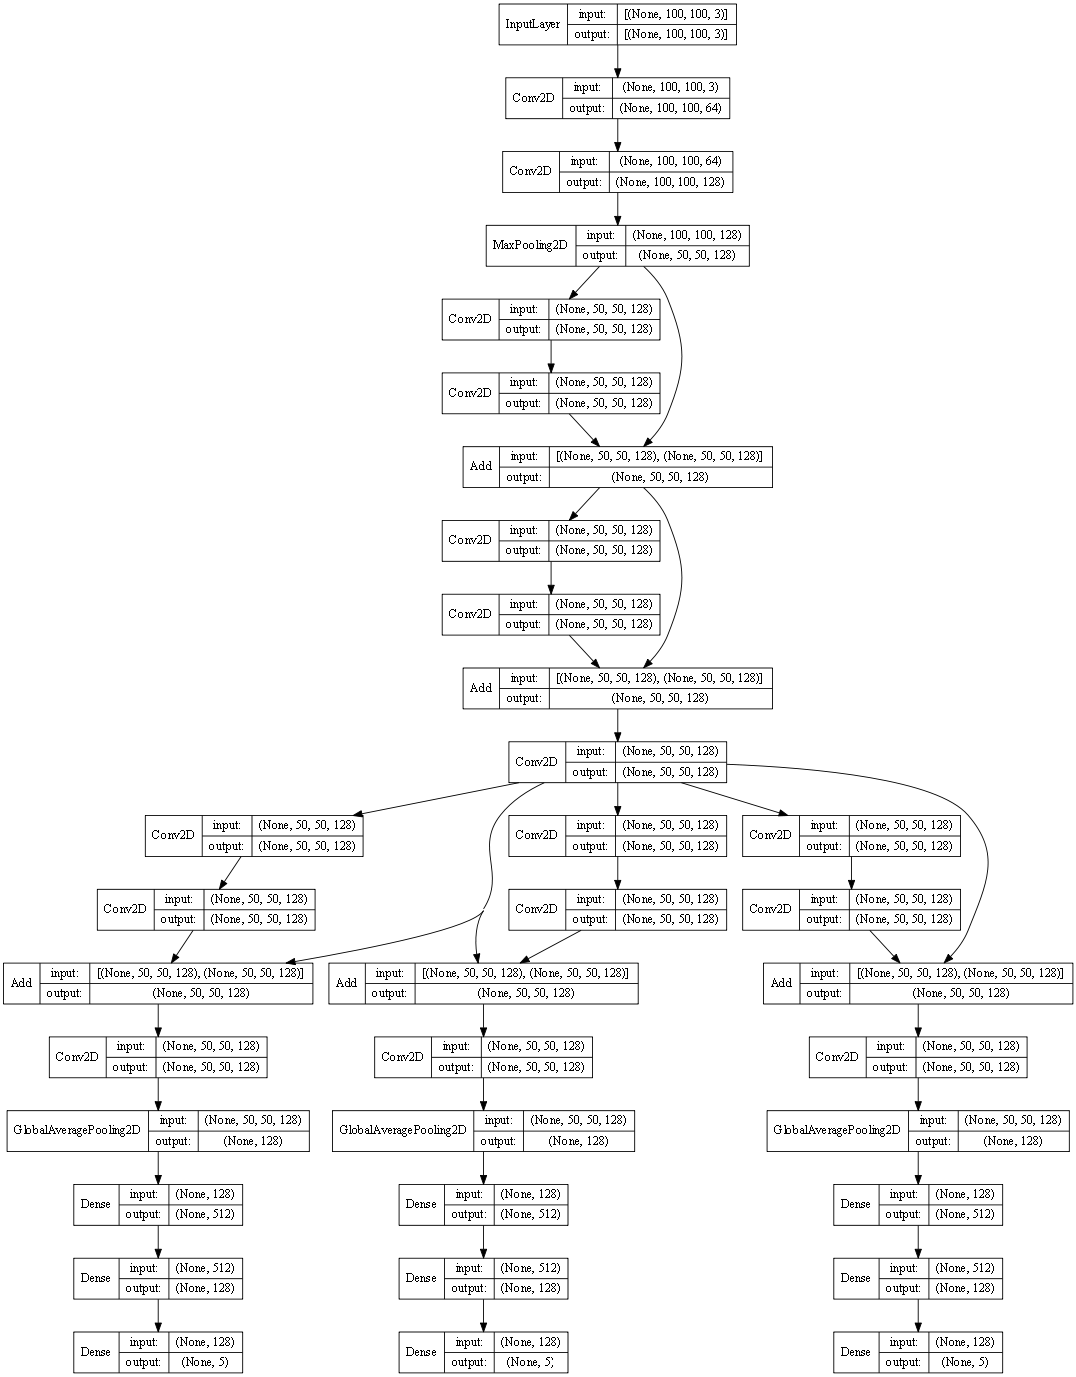

In [8]:
model = Model()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=64, to_file='model.png')
#https://www.twblogs.net/a/5db37762bd9eee310da04cee

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 128 73856       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 50, 128)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1),
    loss={
        "circle": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "square": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "triangle": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    },
    metrics=['accuracy'],
    loss_weights=[1.0, 1.0, 1.0],
)

In [10]:
filepath = "./fresh_model/saved-model-{epoch:02d}.hdf5"
history = model.fit(
    {"input": train_images},
    {"circle": circle_labels, "square": square_labels, "triangle": triangle_labels},
    validation_split=0.1,
    epochs=epochs,
    batch_size=100,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=False)],
)

Epoch 1/20
450/450 [==============================] - 175s 373ms/step - loss: 4.5687 - circle_loss: 1.5309 - square_loss: 1.5025 - triangle_loss: 1.5353 - circle_accuracy: 0.2812 - square_accuracy: 0.3000 - triangle_accuracy: 0.2674 - val_loss: 2.4353 - val_circle_loss: 0.8216 - val_square_loss: 0.8021 - val_triangle_loss: 0.8116 - val_circle_accuracy: 0.6152 - val_square_accuracy: 0.6498 - val_triangle_accuracy: 0.6504
Epoch 2/20
450/450 [==============================] - 165s 366ms/step - loss: 1.7402 - circle_loss: 0.5641 - square_loss: 0.5868 - triangle_loss: 0.5894 - circle_accuracy: 0.7690 - square_accuracy: 0.7517 - triangle_accuracy: 0.7536 - val_loss: 0.6211 - val_circle_loss: 0.1781 - val_square_loss: 0.2452 - val_triangle_loss: 0.1978 - val_circle_accuracy: 0.9410 - val_square_accuracy: 0.9050 - val_triangle_accuracy: 0.9348
Epoch 3/20
450/450 [==============================] - 165s 367ms/step - loss: 0.5568 - circle_loss: 0.1674 - square_loss: 0.1779 - triangle_loss: 0.2116

circle:


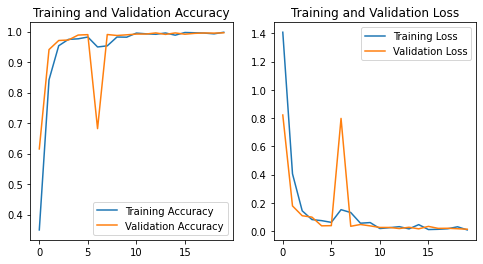

square:


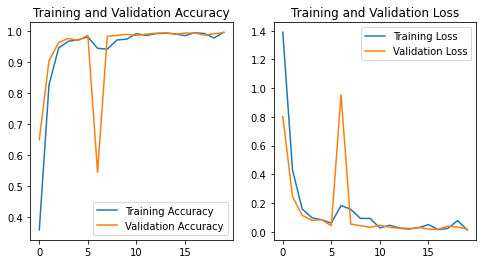

triangle:


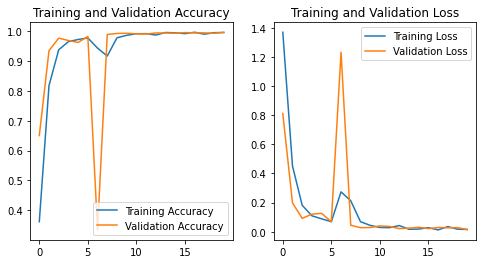

In [11]:
epochs_range = range(epochs)

print('circle:')
acc = history.history['circle_accuracy']
val_acc = history.history['val_circle_accuracy']

loss = history.history['circle_loss']
val_loss = history.history['val_circle_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('square:')
acc = history.history['square_accuracy']
val_acc = history.history['val_square_accuracy']

loss = history.history['square_loss']
val_loss = history.history['val_square_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print('triangle:')
acc = history.history['triangle_accuracy']
val_acc = history.history['val_triangle_accuracy']

loss = history.history['triangle_loss']
val_loss = history.history['val_triangle_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()